In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [49]:
# Load and preprocess the dataset
file_path = 'rooms_dataset.npy'
rooms_dataset = np.load(file_path)

# Ensure the data has a channels dimension (assumed to be grayscale)
rooms_dataset = np.expand_dims(rooms_dataset, axis=-1)  # Adding channel dimension if not present
rooms_dataset_normalized = rooms_dataset / np.max(rooms_dataset)
rooms_dataset_normalized = rooms_dataset_normalized.astype(np.float32)

print("Shape of input data:", rooms_dataset_normalized.shape)  # Should be (num_samples, height, width, channels)

Shape of input data: (1157, 16, 16, 1)


In [50]:
def augment_data(dataset):
    augmented_dataset = []
    for image in dataset:
        image = np.squeeze(image)  # Remove channel dimension for augmentation
        # Apply random transformations
        image = np.rot90(image, k=np.random.randint(4))
        if np.random.rand() > 0.5:
            image = np.fliplr(image)
        if np.random.rand() > 0.5:
            image = np.flipud(image)
        augmented_dataset.append(image)
    return np.expand_dims(np.array(augmented_dataset), axis=-1)  # Add channel dimension back

rooms_dataset_augmented = augment_data(rooms_dataset_normalized)


In [51]:
# Split dataset into training and validation sets
split_ratio = 0.8
split_index = int(split_ratio * len(rooms_dataset_normalized))

train_dataset = rooms_dataset_normalized[:split_index]
val_dataset = rooms_dataset_normalized[split_index:]

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")


Training set size: 925
Validation set size: 232


In [52]:

# Define the VAE model components

# # Encoder
# def build_encoder(input_shape, latent_dim):
#     inputs = layers.Input(shape=input_shape)
#     x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     x = layers.MaxPooling2D((2, 2), padding='same')(x)
#     x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = layers.MaxPooling2D((2, 2), padding='same')(x)
#     x = layers.Flatten()(x)
#     x = layers.Dense(128, activation='relu')(x)

#     z_mean = layers.Dense(latent_dim)(x)
#     z_log_var = layers.Dense(latent_dim)(x)

#     return models.Model(inputs, [z_mean, z_log_var], name="encoder")

# # Decoder
# def build_decoder(latent_dim, output_shape):
#     latent_inputs = layers.Input(shape=(latent_dim,))
#     x = layers.Dense(4 * 4 * 64, activation='relu')(latent_inputs)  # Adjust size to match intermediate shape
#     x = layers.Reshape((4, 4, 64))(x)  # Adjust size to match intermediate shape
#     x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
#     x = layers.UpSampling2D((2, 2))(x)  # Shape: (8, 8, 64)
#     x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
#     x = layers.UpSampling2D((2, 2))(x)  # Shape: (16, 16, 32)
#     x = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)  # Shape: (16, 16, 16)
#     outputs = layers.Conv2DTranspose(output_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)  # Shape: (16, 16, 1)

#     return models.Model(latent_inputs, outputs, name="decoder")


# Decoder
def build_decoder(latent_dim, output_shape):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(4 * 4 * 64, activation='relu')(latent_inputs)  # Adjust size to match intermediate shape
    x = layers.Reshape((4, 4, 64))(x)  # Adjust size to match intermediate shape
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # Shape: (8, 8, 64)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # Shape: (16, 16, 32)
    x = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)  # Shape: (16, 16, 16)
    outputs = layers.Conv2DTranspose(output_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)  # Shape: (16, 16, 1)

    return models.Model(latent_inputs, outputs, name="decoder")



# VAE Model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        return reconstructed

    def reparameterize(self, z_mean, z_log_var):
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def compute_loss(self, x, y):
        z_mean, z_log_var = self.encoder(x)
        reconstructed = self.decoder(self.reparameterize(z_mean, z_log_var))

        # Binary cross-entropy loss
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, reconstructed))

        # KL divergence loss with scaling
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))

        # Combining losses with weights
        total_loss = reconstruction_loss + kl_loss * 0.1

        return total_loss

# Hyperparameters
input_shape = rooms_dataset_normalized.shape[1:]  # Shape of input images
latent_dim = 2  # Number of latent dimensions
output_shape = input_shape



In [53]:
encoder = build_enhanced_encoder(input_shape, latent_dim)  # Use build_enhanced_encoder
decoder = build_decoder(latent_dim, output_shape) # Now the build_decoder function is defined and can be called.
vae = VAE(encoder, decoder)

In [54]:
# Compile the model
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        reconstructed = vae(x, training=True)
        loss = vae.compute_loss(x, reconstructed)
    grads = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(grads, vae.trainable_variables))
    return loss

# def train(epochs, batch_size):
#     dataset = tf.data.Dataset.from_tensor_slices(rooms_dataset_normalized).shuffle(1000).batch(batch_size)
#     for epoch in range(epochs):
#         for batch in dataset:
#             loss = train_step(batch)
#         print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy()}")

# # Train the model
# train(epochs=50, batch_size=64)

def train(epochs, batch_size):
    train_ds = tf.data.Dataset.from_tensor_slices(train_dataset).shuffle(1000).batch(batch_size)
    val_ds = tf.data.Dataset.from_tensor_slices(val_dataset).batch(batch_size)

    for epoch in range(epochs):
        # Training
        for batch in train_ds:
            loss = train_step(batch)

        # Validation
        val_loss = tf.keras.metrics.Mean()
        for batch in val_ds:
            val_loss.update_state(vae.compute_loss(batch, batch))

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy()}, Validation Loss: {val_loss.result().numpy()}")

# Train the model
train(epochs=100, batch_size=64)



Epoch 1/100, Loss: 0.3492618203163147, Validation Loss: 0.4537186622619629
Epoch 2/100, Loss: 0.3661477565765381, Validation Loss: 0.44387173652648926
Epoch 3/100, Loss: 0.35669779777526855, Validation Loss: 0.4426337480545044
Epoch 4/100, Loss: 0.357119083404541, Validation Loss: 0.4563891887664795
Epoch 5/100, Loss: 0.3205670714378357, Validation Loss: 0.4416847229003906
Epoch 6/100, Loss: 0.3161851167678833, Validation Loss: 0.44188788533210754
Epoch 7/100, Loss: 0.35339003801345825, Validation Loss: 0.44689133763313293
Epoch 8/100, Loss: 0.38451021909713745, Validation Loss: 0.44215986132621765
Epoch 9/100, Loss: 0.38458123803138733, Validation Loss: 0.4409007132053375
Epoch 10/100, Loss: 0.3043728768825531, Validation Loss: 0.4483341574668884
Epoch 11/100, Loss: 0.34008607268333435, Validation Loss: 0.44244736433029175
Epoch 12/100, Loss: 0.32090526819229126, Validation Loss: 0.44793739914894104
Epoch 13/100, Loss: 0.3317447006702423, Validation Loss: 0.4319906532764435
Epoch 14/1

1/1 [==============================] - 0s 26ms/step


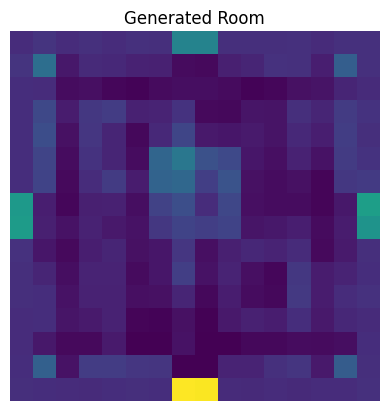

In [57]:
# Generate new rooms
def generate_room(latent_dim, decoder):
    z = np.random.normal(size=(1, latent_dim))
    generated_room = decoder.predict(z)
    return generated_room[0]



# Generate and display a new room
new_room = generate_room(latent_dim, decoder)
plt.imshow(new_room.squeeze(), cmap='viridis')
plt.title('Generated Room')
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 68ms/step


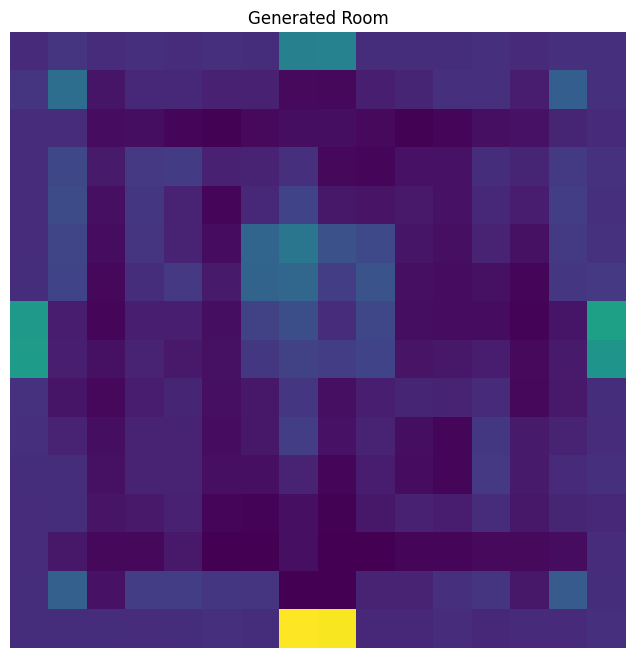

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def generate_room(latent_dim, decoder):
    # Generate random latent vector
    z = np.random.normal(size=(1, latent_dim))

    # Predict the room using the decoder
    generated_room = decoder.predict(z)

    # Post-process the image
    generated_room = generated_room[0]

    # Normalize to [0, 1] if not already normalized
    if generated_room.max() > 1:
        generated_room = (generated_room - generated_room.min()) / (generated_room.max() - generated_room.min())

    # Convert to 0-255 integer values
    generated_room = np.clip(generated_room * 255, 0, 255).astype(np.uint8)

    return generated_room

def display_room(image_array, cmap='viridis'):
    plt.figure(figsize=(8, 8))
    plt.imshow(image_array.squeeze(), cmap=cmap)
    plt.title('Generated Room')
    plt.axis('off')
    plt.show()

# Generate and display a new room
new_room = generate_room(latent_dim, decoder)
display_room(new_room, cmap='viridis')
